# Building Segmentation on Satellite Images

The purpose of this project is to train a deep learning model to segment buildings from Satellite Imagery. I chose this as my project because it is a topic and task I could see myself using in my job daily. I enjoy working with geospatial data or any remote sensing data in general so this dataset stood out to me. Additionally, I work with image processing type of tasks regruarly and I wanted to try out an image segmentation project. 

Image segmentation is something like the combination of classification and localization. Classification of two target classes may look like deciding what classes are present in an image, while localization is determining where those classes are in the image. In this case the two classes are building or background. The problem is solved pixel by pixel by grouping similar pixels. 

I chose to use a U-Net for this problem since it was specifically designed for image segmentation problems in 2015 for the use on biomedical images. A model such as the U-Net that I train here or another deep learning model which segments buildings from Satellite Imagery could be useful in many applications. Automatically creating ground use maps, monitoring locations, tax assessments and many more uses are extremely valuable tools for many businesses or organizations. I chose this U-Net architecture because . I am using the CrowdAI Mapping-Challenge which you can find here: https://www.crowdai.org/challenges/mapping-challenge

There is also a github repository for this project located here: https://github.com/emhi6821/SetelliteImageSegmentation_UNet



In [11]:
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import glob
from matplotlib.path import Path
from skimage.color import label2rgb
from sklearn.model_selection import train_test_split
import keras
from keras import layers
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import random
from PIL import Image
from keras.callbacks import CSVLogger
import os
import sys
import time
import skimage.io
import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
from IPython.display import clear_output
import keras_cv
import tensorflow as tf
import json
import pandas as pd
#from tensorflow import keras
#from tensorflow.keras import layers, backend
#from keras.models import Model
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras.optimizers import Adam
#from keras.layers import Activation, MaxPool2D, Concatenate


## Load Data
The data consists of satellite imagery in the form of .jpg images and annotation .csv files with segmentation and bounding box information for buildings in the satellite imagery. Later on I will make the target images, essentially binary masks, out of the segmentations. 

Below I load the data. The dataset from CrowdAI included training, validation and test data. This is data froma challenge so the test data does not have labels so I will be using a subset of train that gets set aside for testing (in addition to validation dataset). At first I loaded in the validation and training datasets, combined them into one and then split into train, test and validation, but the dataset is so large that I ended up only using a subset of the train dataset to make my own train, test and validation. 

In [8]:
data_dir = 'Data'
train_img_dir = 'Data/train/images'
#val_img_dir = 'Data/val/images'
train_dir = 'Data/train'
#val_dir = 'Data/val'
glob.glob('Data/train/*')

['Data/train/annotation.json',
 'Data/train/annotation-small.json',
 'Data/train/images']

In [9]:
train_annots = train_dir+'/annotation.json'
#val_annots = val_dir+'/annotation.json'

with open(train_annots, 'r') as f:
    train_annot_data = json.load(f)
#with open(val_annots, 'r') as f:
#    val_annot_data = json.load(f)

## Exploratory Data Analysis (EDA)

The training data subset that will be used is defined below. I use a 25,000 image subset because the entire data is just too large to work with. There are 5 columns in the dataset after I add the dataset column which will be used for the paths to retrieve input and target images. All images are 300x300x3 RGB images. 

After viewing the training dataframe, 4 example satellite images (input) are plotted.  

In [37]:
train_image_df = pd.DataFrame(train_annot_data['images'])[:25000]
#val_image_df = pd.DataFrame(val_annot_data['images'])
#val_image_df['dataset'] = 'val'
train_image_df['dataset'] = 'train'
print(train_image_df)
#print(val_image_df)


           id         file_name  width  height dataset
0      239047  000000239047.jpg    300     300   train
1       37213  000000037213.jpg    300     300   train
2      115886  000000115886.jpg    300     300   train
3      135786  000000135786.jpg    300     300   train
4       75474  000000075474.jpg    300     300   train
...       ...               ...    ...     ...     ...
24995    6560  000000006560.jpg    300     300   train
24996   50894  000000050894.jpg    300     300   train
24997   32187  000000032187.jpg    300     300   train
24998  258659  000000258659.jpg    300     300   train
24999  181976  000000181976.jpg    300     300   train

[25000 rows x 5 columns]


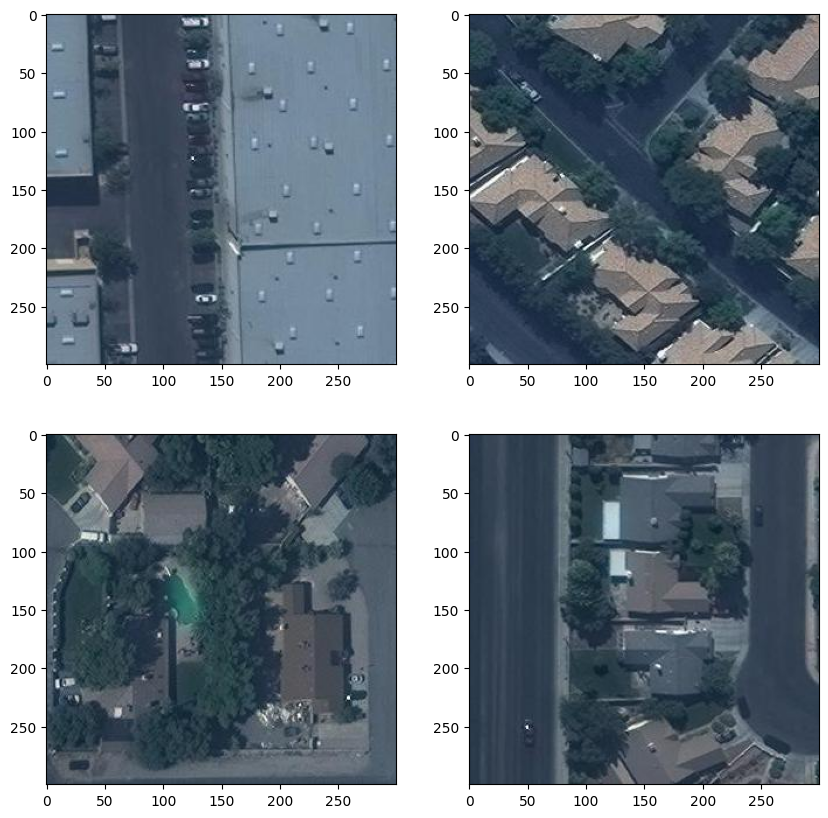

In [38]:
#Dataframe of all images
images_df = train_image_df #pd.concat([train_image_df, val_image_df])
images_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), images_df.sample(4).iterrows()):
    img_data = imread(os.path.join(data_dir, c_row['dataset'], 'images', c_row['file_name']))
    c_ax.imshow(img_data)

Next the dataframe for the annotations is created and then I merge that with the training images dataframe. There can be multiple annotations per image so the resulting full dataframe has more than 25,000 rows (the number of unique satellite images we are using).

A function called create_boxes is created to convert the segmentation annotations into rectangle objects that can be plotted on top of imagery.

In [14]:
annot_df = pd.DataFrame(train_annot_data['annotations'])
annot_df.head()

id  image_id                                       segmentation  \
0  460757     54062  [[300, 182, 297, 182, 296, 153, 300, 153, 300,...   
1  266461     31255  [[19.0, 234.0, 19.0, 245.0, 0.0, 246.0, 0.0, 2...   
2  313854     36754  [[133.0, 42.0, 133.0, 4.000000000000001, 197.0...   
3  278729     32649  [[125.0, 247.0, 125.0, 300.0, 37.0, 300.0, 36....   
4  509969     59769  [[200.0, 300.0, 212.0, 280.0, 227.0, 293.0, 23...   

     area                                     bbox  category_id  iscrowd  
0   101.0                       [182, 296, 118, 4]          100        0  
1   218.0                  [0.0, 0.0, 245.0, 19.0]          100        0  
2  2432.0  [4.000000000000001, 133.0, 193.0, 64.0]          100        0  
3  4647.0                [37.0, 36.0, 263.0, 89.0]          100        0  
4  4122.0              [200.0, 200.0, 100.0, 92.0]          100        0

In [15]:
full_df = pd.merge(annot_df, images_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(full_df.head())
print('Full DataFrame length: ', len(full_df))

       id_x  image_id                                       segmentation  \
2    313854     36754  [[133.0, 42.0, 133.0, 4.000000000000001, 197.0...   
12  1439437    168845  [[73, 280, 73, 299, 30, 299, 30, 280, 7, 281, ...   
22  2101611    246498  [[79, 50, 99, 107, 64, 115, 59, 101, 48, 103, ...   
31  1386712    162701  [[6.9999999999999964, 122.00000000000003, -3.4...   
34  1451390    170274  [[221.0, 71.0, 220.0, 47.0, 202.0, 48.0, 201.0...   

      area                                               bbox  category_id  \
2   2432.0            [4.000000000000001, 133.0, 193.0, 64.0]          100   
12  3151.0                                    [7, 6, 292, 82]          100   
22  3325.0                                   [48, 16, 67, 83]          100   
31    91.0  [-5.021051876504148e-15, -5.021051876504148e-1...          100   
34  3397.0                         [22.0, 195.0, 199.0, 68.0]          100   

    iscrowd      id_y         file_name  width  height dataset  
2        

In [16]:
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

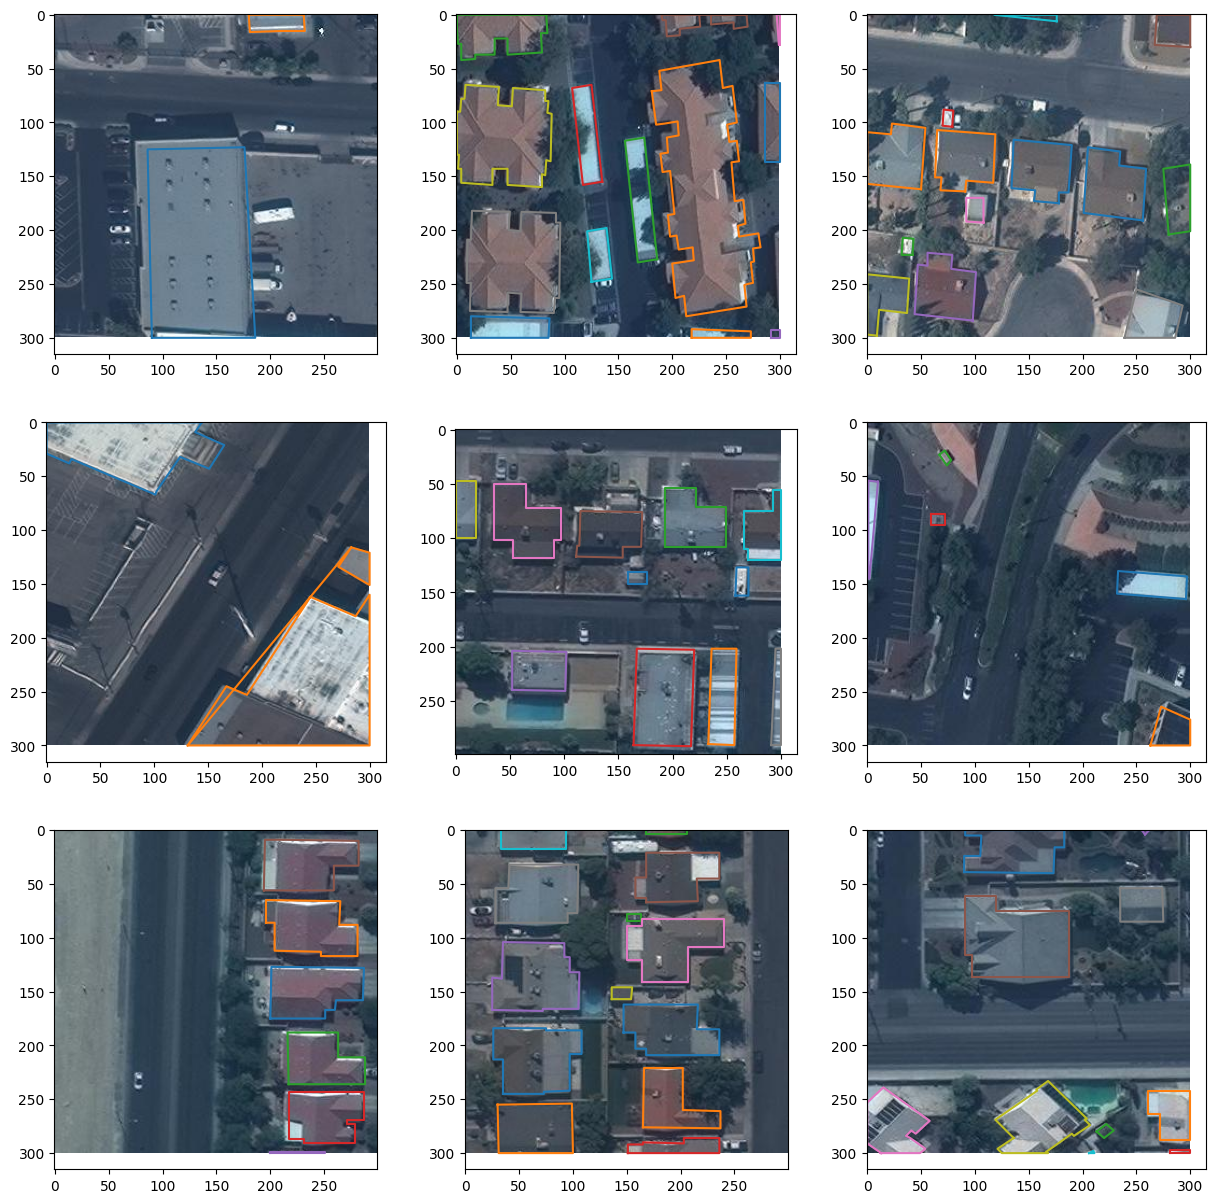

In [17]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 15))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(data_dir, c_df['dataset'].values[0], 'images', c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #print(img_data.shape)
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

### Convert Polygons to Segmented Images

Below a function called rows_to_segmentation is created to turn the annotation data segmentations into a binary mask where 0 is background and 1 is buildings. After creating the function 3 examples are plotted (1 example per row). The left column is the imagery with segmentations plotted as rectangles on top of imagery, then the binary mask is plotted in the middle column and the opposite mask in the third column. This gives you a good idea of the data we are working with and the formats we have it in. 

In [18]:
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

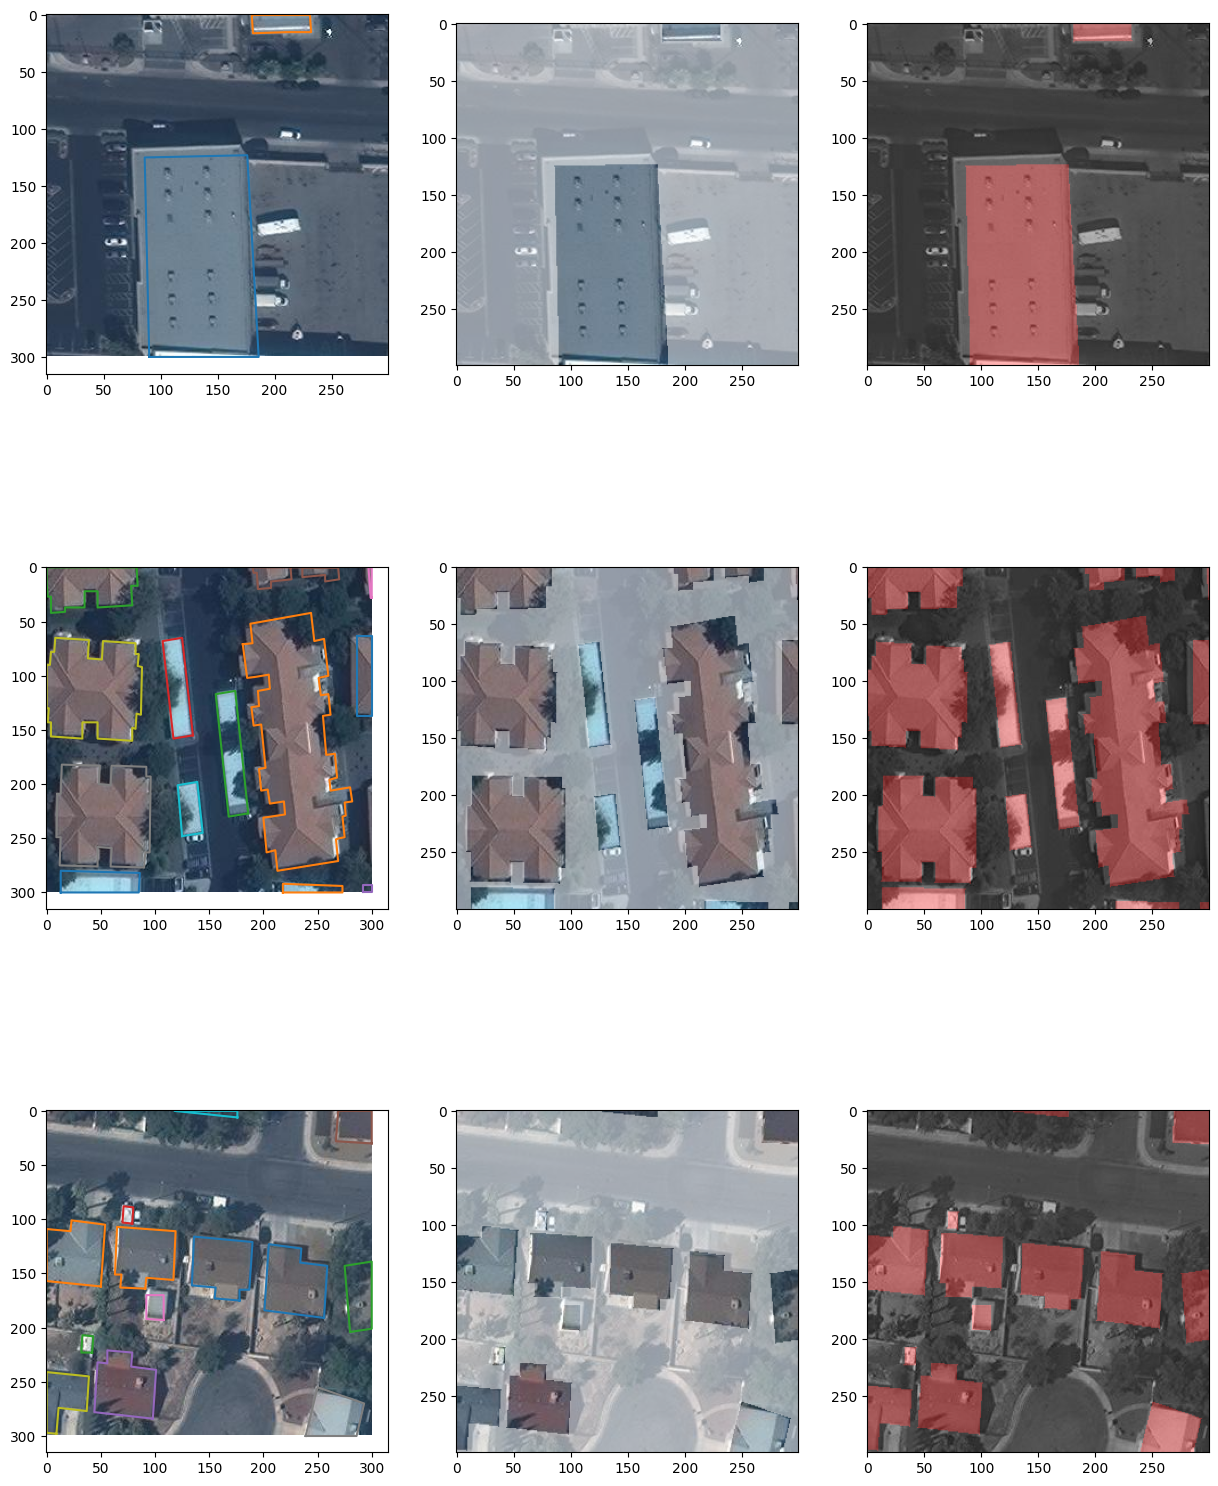

In [19]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(data_dir, c_df['dataset'].values[0], 'images', c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

Next, I split the data into train, test and val datasets. Train will be 65% of the entire data. Then I use 35% split evenly for the validation and test dataset. 

In [20]:
train_ids, valid_ids = train_test_split(images_df['id'], test_size = 0.35, random_state = 43)
test_ids, valid_ids = train_test_split(valid_ids, test_size = 0.5, random_state=43)

full_df['path'] = r'Data/'+full_df['dataset']+'/images/'+full_df['file_name']
full_df['target_path'] = r'Data/targets/train/'+full_df['file_name']
full_df['target_path'] = full_df['target_path'].replace('jpg', 'png')

train_df = full_df[full_df['image_id'].isin(train_ids)].reset_index(drop=True)
valid_df = full_df[full_df['image_id'].isin(valid_ids)].reset_index(drop=True)
test_df = full_df[full_df['image_id'].isin(test_ids)].reset_index(drop=True)

print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')
print(test_df.shape[0], 'test boxes \n\n')

print(full_df.info(), '\n\n')
print(full_df.head())

138438 training boxes
37410 validation boxes
36579 test boxes 


<class 'pandas.core.frame.DataFrame'>
Index: 212427 entries, 2 to 2395552
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_x          212427 non-null  int64  
 1   image_id      212427 non-null  int64  
 2   segmentation  212427 non-null  object 
 3   area          212427 non-null  float64
 4   bbox          212427 non-null  object 
 5   category_id   212427 non-null  int64  
 6   iscrowd       212427 non-null  int64  
 7   id_y          212427 non-null  float64
 8   file_name     212427 non-null  object 
 9   width         212427 non-null  float64
 10  height        212427 non-null  float64
 11  dataset       212427 non-null  object 
 12  path          212427 non-null  object 
 13  target_path   212427 non-null  object 
dtypes: float64(4), int64(4), object(6)
memory usage: 24.3+ MB
None 


       id_x  image_id                                

Text(0.5, 1.0, 'Data Split')

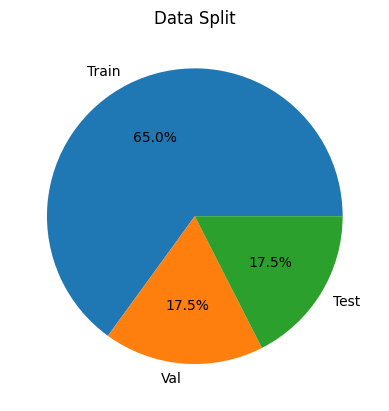

In [21]:
labels = ['Train', 'Val', 'Test']
sizes = [len(train_ids), len(valid_ids), len(test_ids)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%')
plt.title('Data Split')

### Visualize the Target Output

In the plot grid below, the 'Mask Only' column is what will be used as the target for my model. The input is the 'Imagery Only Column'. After visualizing the 6 masks to ensure they are what I want, I save the images to my local machine. At first I was saving these images with PIL in .jpg format but I would save them out as a binary image with 0 and 255 integer values, but when I would read them back in they would have a range of integer values around 0 and 255. The 0 value is background and 255 is building; since these values are the classes of the target data it is important that they are the exact correct values. I switched to saving in .png format and this solved the problem; when I read in those .png images they keep the same values as the numpy array used to create them with only two classes. 

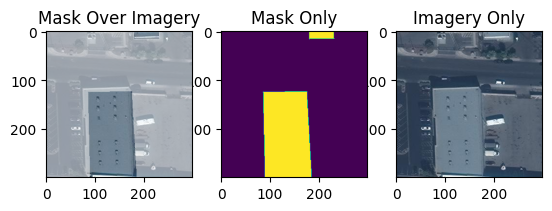

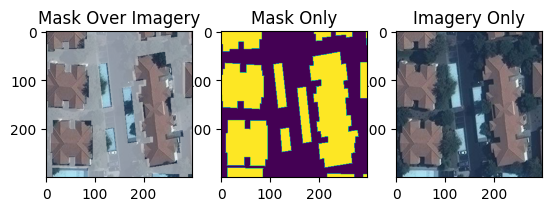

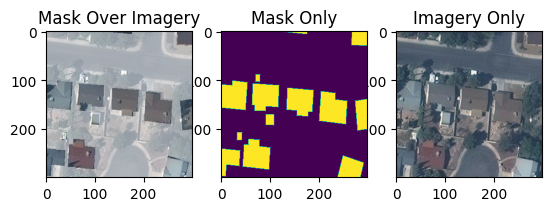

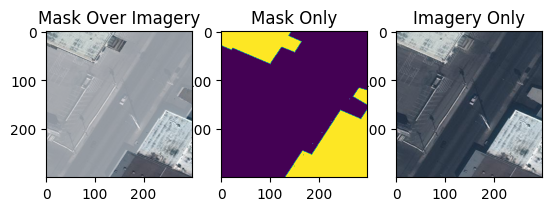

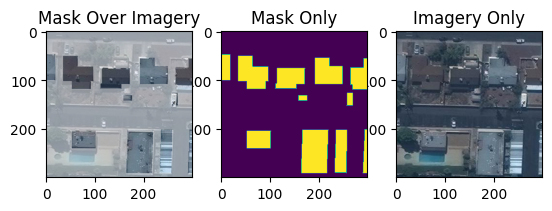

In [22]:
i = 0
for (c_id, c_df) in full_df.groupby('image_id'):
    i+=1
    if i < 6:
        img_data = imread(os.path.join(data_dir, c_df['dataset'].values[0], 'images', c_df['file_name'].values[0]))
        out_img = rows_to_segmentation(img_data, c_df)
        plt.subplot(133)
        plt.imshow(img_data)
        plt.title('Imagery Only')
        
        plt.subplot(132)
        plt.imshow(out_img)
        plt.title('Mask Only')
        rgba_img = np.concatenate([img_data, 
                                   np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                                  ], -1)
        plt.subplot(131)
        plt.imshow(rgba_img)
        plt.title('Mask Over Imagery')
        plt.show()

In [24]:
#Save all bool masks - target images
for (c_id, c_df) in full_df.groupby('image_id'):
        img_data = imread(os.path.join(data_dir, c_df['dataset'].values[0], 'images', c_df['file_name'].values[0]))
        out_img = rows_to_segmentation(img_data, c_df)

        mask_path = os.path.join(data_dir, 'targets',c_df['dataset'].values[0], c_df['file_name'].values[0]).replace('jpg', 'png')

        #print(mask_path)
        out_img[out_img==2] = 1
        #print(np.unique(out_img.astype('uint8')*255))
    
        #plt.imshow(out_img.astype('uint8'))
        #plt.show()
        #im = Image.fromarray(out_img.astype('uint8')*255)
        #im.save(mask_path)

In [25]:
#Get lists of all input/target image paths
train_target_img_paths = list(train_df['target_path'].unique())
val_target_img_paths = list(valid_df['target_path'].unique())
test_target_img_paths = list(test_df['target_path'].unique())

train_target_img_paths = [x.replace('jpg', 'png') for x in train_target_img_paths]
test_target_img_paths = [x.replace('jpg', 'png') for x in test_target_img_paths]
val_target_img_paths = [x.replace('jpg', 'png') for x in val_target_img_paths]

test_input_img_paths = list(test_df['path'].unique())
val_input_img_paths = list(valid_df['path'].unique())
train_input_img_paths = list(train_df['path'].unique())

In [26]:
def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    x = x[:224,:224]
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks

def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 128
OUT_CLASSES = 1
#Get lists of all input/target image paths
train_target_img_paths = list(train_df['target_path'].unique())
val_target_img_paths = list(valid_df['target_path'].unique())
test_target_img_paths = list(test_df['target_path'].unique())

train_target_img_paths = [x.replace('jpg', 'png') for x in train_target_img_paths]
test_target_img_paths = [x.replace('jpg', 'png') for x in test_target_img_paths]
val_target_img_paths = [x.replace('jpg', 'png') for x in val_target_img_paths]

test_input_img_paths = list(test_df['path'].unique())
val_input_img_paths = list(valid_df['path'].unique())
train_input_img_paths = list(train_df['path'].unique())

train_dataset = load_dataset(
    train_input_img_paths, train_target_img_paths, 224, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_input_img_paths, val_target_img_paths, 224, OUT_CLASSES, BATCH_SIZE, shuffle=False
)
test_dataset = load_dataset(
    test_input_img_paths, test_target_img_paths, 224, OUT_CLASSES, BATCH_SIZE, shuffle=False
)
print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")
print(f"Test Dataset: {test_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>


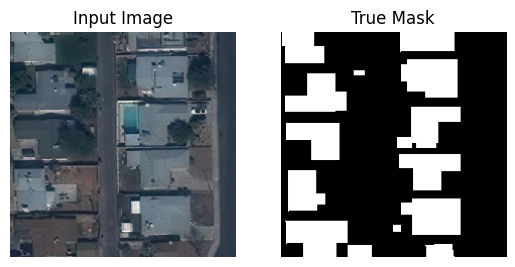

2024-04-29 10:22:09.567220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()

for image, mask in val_dataset.take(1):
    display([image[0], mask[0]])

In [28]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique(mask))
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 2
Unique values:
[0. 1.]
[  0 255]


In [29]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

## Create the U-Net Model

A U-Net is a encoder-decoder Convolutional Neural Network (CNN). An diagram of a generalized U-net architecture is shown below. Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations.

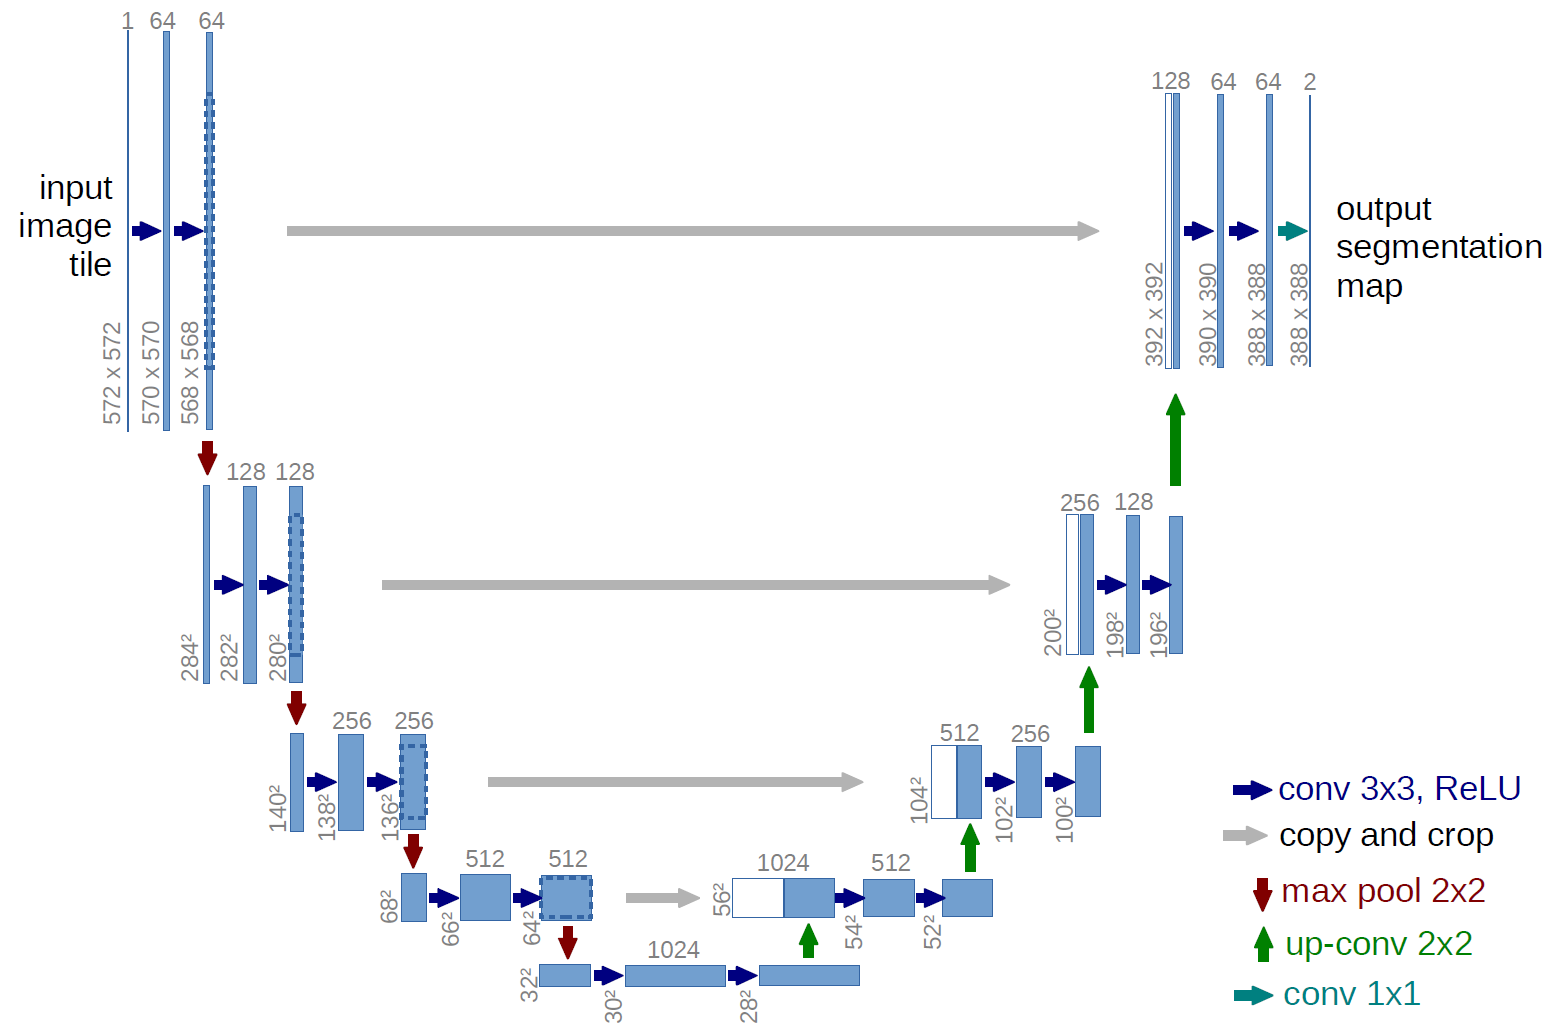


U-Net gets its name from its architecture. The “U” shaped model comprises convolutional layers and two networks. First is the encoder, which is followed by the decoder.

The encoder network learns a feature map of the input image and tries to determine what is n the image, similar to any classification task with CNNs, except there are not any fully connected layers at the end. The required output is not the class label but a mask of the same size as our input image. The decoder network upsamples the feature maps to the size of the input image. The decoder network determines where the classes are in the imagery. Skip connections help us use the high-resolution features learned from the encoder blocks (through skip connections) to project the feature map (output of the bottleneck layer).

Below the model is created with a MobileNetV2 base model for the down stack and a U-Net model is created on top of that. The summary of the model is shown after compiling. 

In [77]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [78]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [79]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [80]:
model = unet_model(output_channels=3)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ [(None, 112, 112, │  1,841,984 │ input_layer_8[0]… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 14, 14,    │  1,476,608 │ functional_9[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 14, 14,    │          0 │ sequential_4[0][… │
│ (Concatenate)       │ 1088)             │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 28, 28,    │  2,507,776 │ concatenate_8[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 28, 28,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 448)              │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 56, 56,    │    516,608 │ concatenate_9[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 56, 56,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 272)              │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 112, 112,  │    156,928 │ concatenate_10[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 112, 112,  │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 160)              │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 224, 224,  │      4,323 │ concatenate_11[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

## Predictions Before Training

2024-04-28 17:21:27.878033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


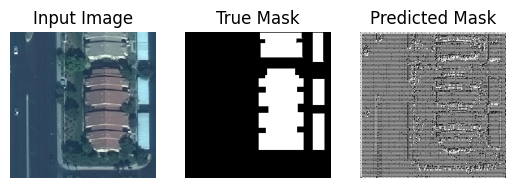

2024-04-28 17:21:33.458851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [83]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      pred_mask =  create_mask(pred_mask)
      display([image[0], mask[0], pred_mask])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(train_dataset)

In [84]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Train the Model

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/stepp - accuracy: 0.8200 - loss: 0.42


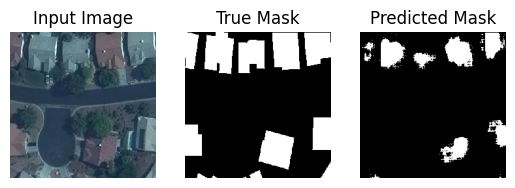


Sample Prediction after epoch 1

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.8204 - loss: 0.4283 - val_accuracy: 0.8680 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.8984 - loss: 0.246


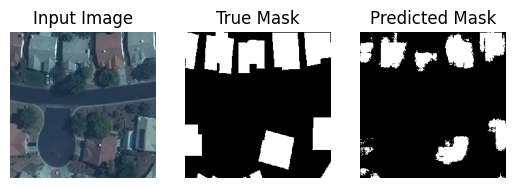


Sample Prediction after epoch 2

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.8985 - loss: 0.2458 - val_accuracy: 0.8909 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9067 - loss: 0.226


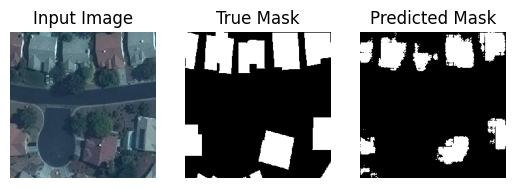


Sample Prediction after epoch 3

127/127 ━━━━━━━━━━━━━━━━━━━━ 1173s 9s/step - accuracy: 0.9068 - loss: 0.2263 - val_accuracy: 0.8983 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9102 - loss: 0.218


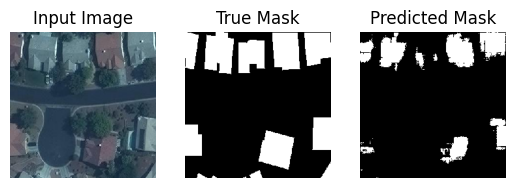


Sample Prediction after epoch 4

127/127 ━━━━━━━━━━━━━━━━━━━━ 1173s 9s/step - accuracy: 0.9103 - loss: 0.2183 - val_accuracy: 0.8840 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9120 - loss: 0.214


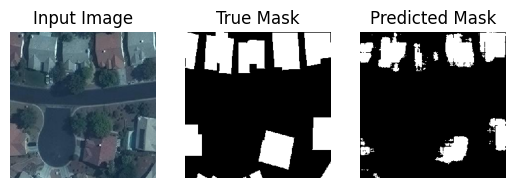


Sample Prediction after epoch 5

127/127 ━━━━━━━━━━━━━━━━━━━━ 1179s 9s/step - accuracy: 0.9120 - loss: 0.2144 - val_accuracy: 0.8984 - val_loss: 0.2499 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9146 - loss: 0.208


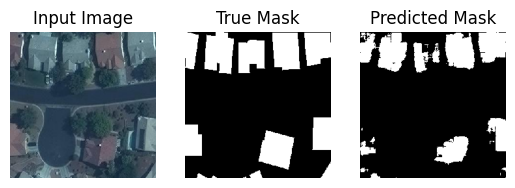


Sample Prediction after epoch 6

127/127 ━━━━━━━━━━━━━━━━━━━━ 1182s 9s/step - accuracy: 0.9147 - loss: 0.2085 - val_accuracy: 0.9105 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9168 - loss: 0.203


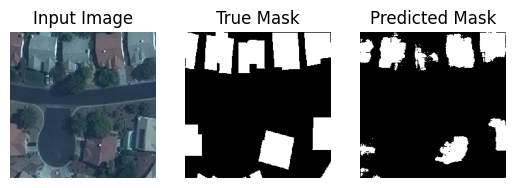


Sample Prediction after epoch 7

127/127 ━━━━━━━━━━━━━━━━━━━━ 1185s 9s/step - accuracy: 0.9169 - loss: 0.2035 - val_accuracy: 0.9032 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9161 - loss: 0.205


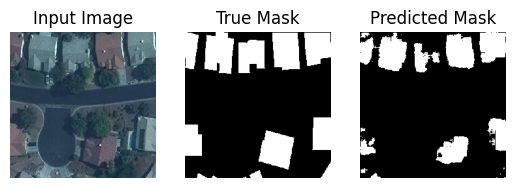


Sample Prediction after epoch 8

127/127 ━━━━━━━━━━━━━━━━━━━━ 1183s 9s/step - accuracy: 0.9162 - loss: 0.2050 - val_accuracy: 0.9125 - val_loss: 0.2177 - learning_rate: 0.0010
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9197 - loss: 0.197


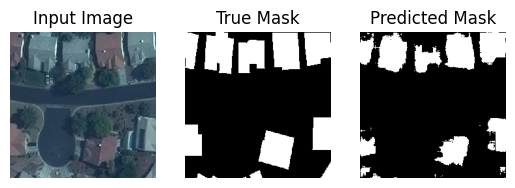


Sample Prediction after epoch 9

127/127 ━━━━━━━━━━━━━━━━━━━━ 1186s 9s/step - accuracy: 0.9198 - loss: 0.1969 - val_accuracy: 0.9155 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9216 - loss: 0.192


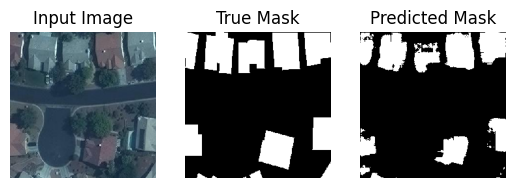


Sample Prediction after epoch 10

127/127 ━━━━━━━━━━━━━━━━━━━━ 1182s 9s/step - accuracy: 0.9216 - loss: 0.1923 - val_accuracy: 0.9168 - val_loss: 0.2067 - learning_rate: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9207 - loss: 0.194


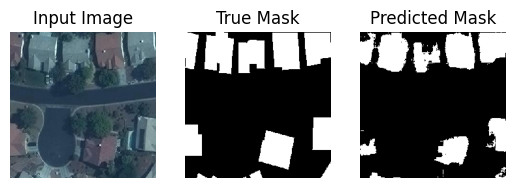


Sample Prediction after epoch 11

127/127 ━━━━━━━━━━━━━━━━━━━━ 1186s 9s/step - accuracy: 0.9208 - loss: 0.1943 - val_accuracy: 0.9158 - val_loss: 0.2051 - learning_rate: 0.0010
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9226 - loss: 0.189


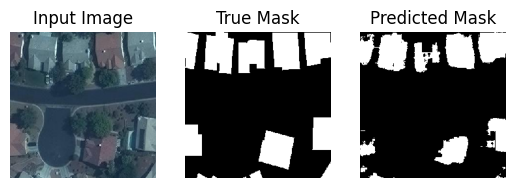


Sample Prediction after epoch 12

127/127 ━━━━━━━━━━━━━━━━━━━━ 1181s 9s/step - accuracy: 0.9226 - loss: 0.1896 - val_accuracy: 0.9155 - val_loss: 0.2135 - learning_rate: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9238 - loss: 0.187


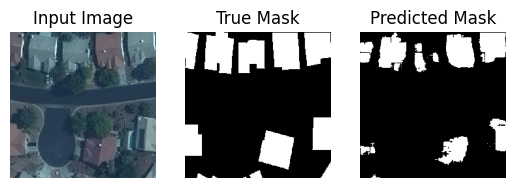


Sample Prediction after epoch 13

127/127 ━━━━━━━━━━━━━━━━━━━━ 1177s 9s/step - accuracy: 0.9239 - loss: 0.1877 - val_accuracy: 0.9042 - val_loss: 0.2436 - learning_rate: 0.0010
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9250 - loss: 0.184


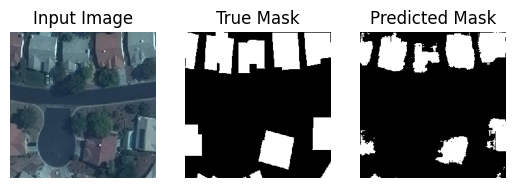


Sample Prediction after epoch 14

127/127 ━━━━━━━━━━━━━━━━━━━━ 1171s 9s/step - accuracy: 0.9251 - loss: 0.1845 - val_accuracy: 0.9168 - val_loss: 0.2062 - learning_rate: 0.0010
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9263 - loss: 0.181


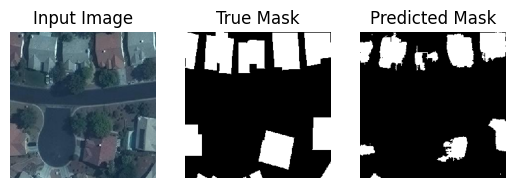


Sample Prediction after epoch 15

127/127 ━━━━━━━━━━━━━━━━━━━━ 1158s 9s/step - accuracy: 0.9264 - loss: 0.1808 - val_accuracy: 0.9012 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9270 - loss: 0.179


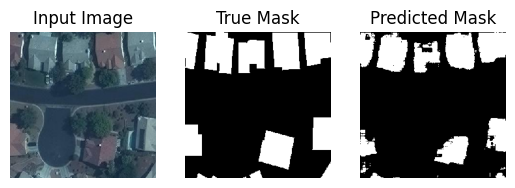


Sample Prediction after epoch 16

127/127 ━━━━━━━━━━━━━━━━━━━━ 1165s 9s/step - accuracy: 0.9271 - loss: 0.1793 - val_accuracy: 0.9187 - val_loss: 0.2083 - learning_rate: 0.0010
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9275 - loss: 0.178


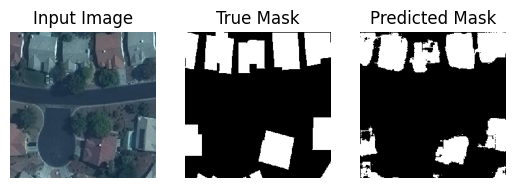


Sample Prediction after epoch 17

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.9276 - loss: 0.1783 - val_accuracy: 0.9207 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9285 - loss: 0.176


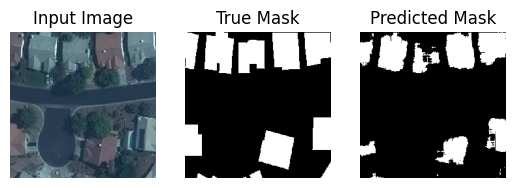


Sample Prediction after epoch 18

127/127 ━━━━━━━━━━━━━━━━━━━━ 1171s 9s/step - accuracy: 0.9286 - loss: 0.1758 - val_accuracy: 0.9182 - val_loss: 0.2090 - learning_rate: 0.0010
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9300 - loss: 0.172


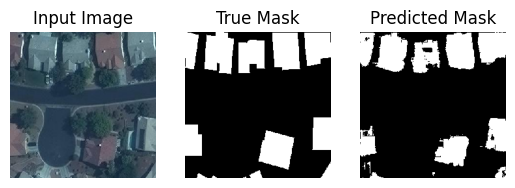


Sample Prediction after epoch 19

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.9300 - loss: 0.1720 - val_accuracy: 0.9221 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9312 - loss: 0.169


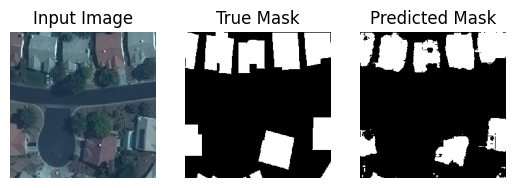


Sample Prediction after epoch 20

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.9313 - loss: 0.1694 - val_accuracy: 0.9236 - val_loss: 0.1981 - learning_rate: 0.0010
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9326 - loss: 0.165


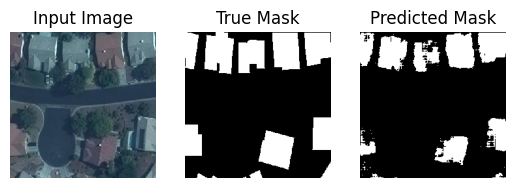


Sample Prediction after epoch 21

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.9327 - loss: 0.1656 - val_accuracy: 0.9217 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9318 - loss: 0.167


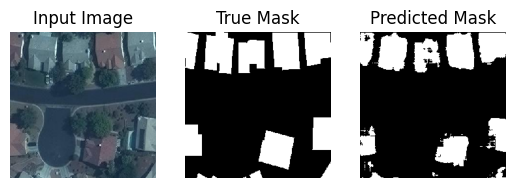


Sample Prediction after epoch 22

127/127 ━━━━━━━━━━━━━━━━━━━━ 1169s 9s/step - accuracy: 0.9319 - loss: 0.1677 - val_accuracy: 0.9235 - val_loss: 0.1977 - learning_rate: 0.0010
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9333 - loss: 0.164


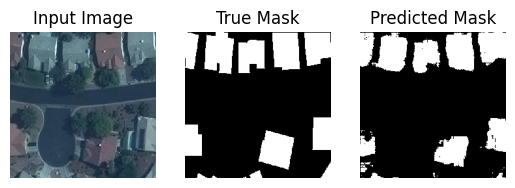


Sample Prediction after epoch 23


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
127/127 ━━━━━━━━━━━━━━━━━━━━ 1167s 9s/step - accuracy: 0.9334 - loss: 0.1638 - val_accuracy: 0.9251 - val_loss: 0.1972 - learning_rate: 0.0010
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepep - accuracy: 0.9358 - loss: 0.159


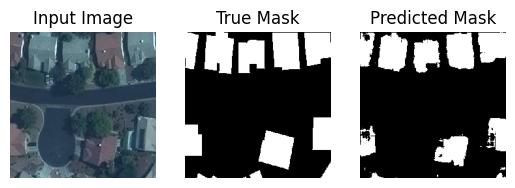


Sample Prediction after epoch 24



2024-04-29 01:11:53.828662: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


127/127 ━━━━━━━━━━━━━━━━━━━━ 1172s 9s/step - accuracy: 0.9358 - loss: 0.1588 - val_accuracy: 0.9276 - val_loss: 0.1862 - learning_rate: 2.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9373 - loss: 0.154


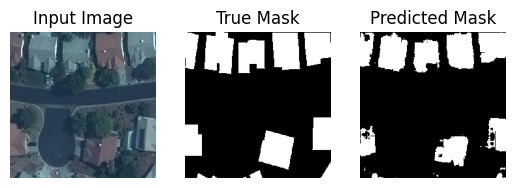


Sample Prediction after epoch 25

127/127 ━━━━━━━━━━━━━━━━━━━━ 1164s 9s/step - accuracy: 0.9374 - loss: 0.1546 - val_accuracy: 0.9271 - val_loss: 0.1899 - learning_rate: 2.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9382 - loss: 0.152


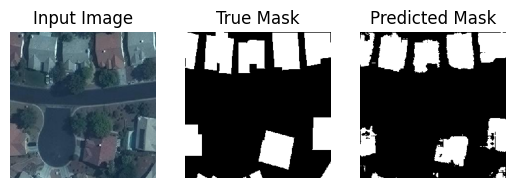


Sample Prediction after epoch 26

127/127 ━━━━━━━━━━━━━━━━━━━━ 1163s 9s/step - accuracy: 0.9382 - loss: 0.1522 - val_accuracy: 0.9276 - val_loss: 0.1879 - learning_rate: 2.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9393 - loss: 0.149


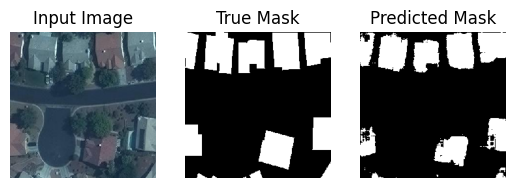


Sample Prediction after epoch 27

127/127 ━━━━━━━━━━━━━━━━━━━━ 1163s 9s/step - accuracy: 0.9394 - loss: 0.1493 - val_accuracy: 0.9275 - val_loss: 0.1895 - learning_rate: 2.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9397 - loss: 0.148


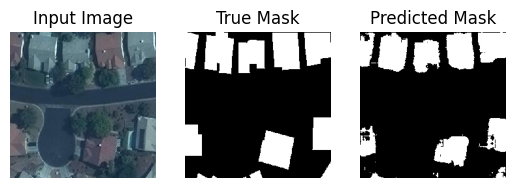


Sample Prediction after epoch 28

127/127 ━━━━━━━━━━━━━━━━━━━━ 1166s 9s/step - accuracy: 0.9398 - loss: 0.1482 - val_accuracy: 0.9276 - val_loss: 0.1904 - learning_rate: 2.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9409 - loss: 0.145


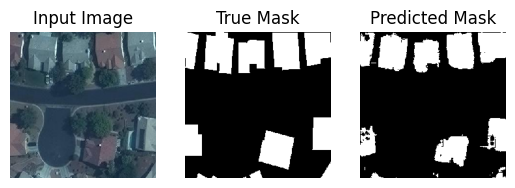


Sample Prediction after epoch 29

127/127 ━━━━━━━━━━━━━━━━━━━━ 1163s 9s/step - accuracy: 0.9410 - loss: 0.1453 - val_accuracy: 0.9269 - val_loss: 0.1915 - learning_rate: 2.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9410 - loss: 0.145


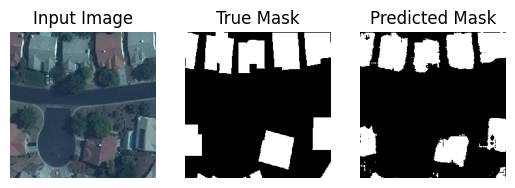


Sample Prediction after epoch 30


Epoch 30: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 1159s 9s/step - accuracy: 0.9411 - loss: 0.1450 - val_accuracy: 0.9278 - val_loss: 0.1903 - learning_rate: 2.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9399 - loss: 0.148


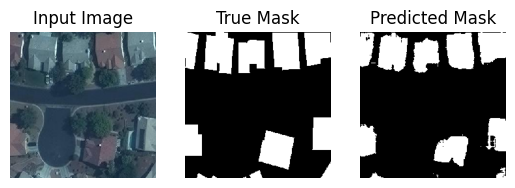


Sample Prediction after epoch 31

127/127 ━━━━━━━━━━━━━━━━━━━━ 1160s 9s/step - accuracy: 0.9400 - loss: 0.1480 - val_accuracy: 0.9315 - val_loss: 0.1805 - learning_rate: 4.0000e-05
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9417 - loss: 0.143


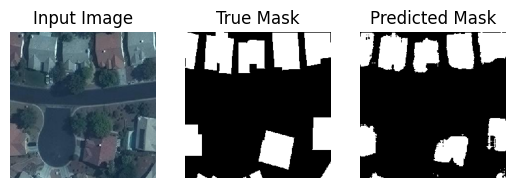


Sample Prediction after epoch 32

127/127 ━━━━━━━━━━━━━━━━━━━━ 1162s 9s/step - accuracy: 0.9418 - loss: 0.1433 - val_accuracy: 0.9316 - val_loss: 0.1804 - learning_rate: 4.0000e-05
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9420 - loss: 0.143


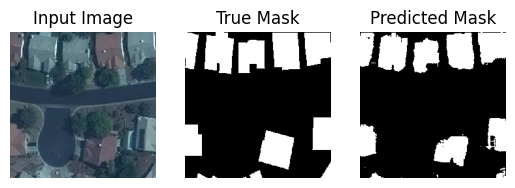


Sample Prediction after epoch 33

127/127 ━━━━━━━━━━━━━━━━━━━━ 1165s 9s/step - accuracy: 0.9420 - loss: 0.1428 - val_accuracy: 0.9317 - val_loss: 0.1803 - learning_rate: 4.0000e-05
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepep - accuracy: 0.9428 - loss: 0.140


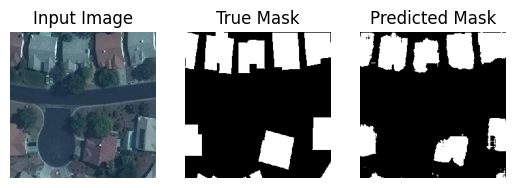


Sample Prediction after epoch 34

127/127 ━━━━━━━━━━━━━━━━━━━━ 1163s 9s/step - accuracy: 0.9429 - loss: 0.1405 - val_accuracy: 0.9318 - val_loss: 0.1810 - learning_rate: 4.0000e-05
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepep - accuracy: 0.9428 - loss: 0.140


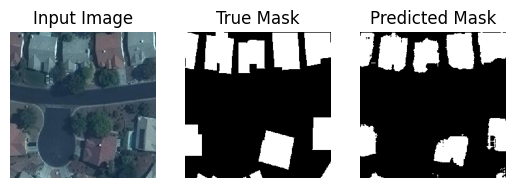


Sample Prediction after epoch 35

127/127 ━━━━━━━━━━━━━━━━━━━━ 1160s 9s/step - accuracy: 0.9429 - loss: 0.1405 - val_accuracy: 0.9318 - val_loss: 0.1806 - learning_rate: 4.0000e-05
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepep - accuracy: 0.9431 - loss: 0.139


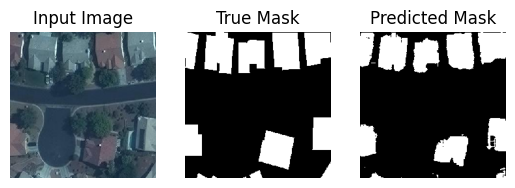


Sample Prediction after epoch 36

127/127 ━━━━━━━━━━━━━━━━━━━━ 1159s 9s/step - accuracy: 0.9432 - loss: 0.1397 - val_accuracy: 0.9319 - val_loss: 0.1808 - learning_rate: 4.0000e-05
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9435 - loss: 0.139


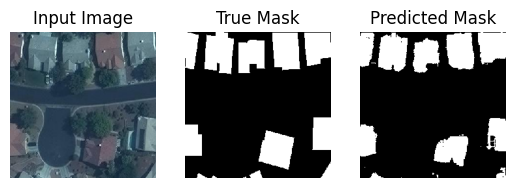


Sample Prediction after epoch 37

127/127 ━━━━━━━━━━━━━━━━━━━━ 1166s 9s/step - accuracy: 0.9436 - loss: 0.1389 - val_accuracy: 0.9318 - val_loss: 0.1807 - learning_rate: 4.0000e-05
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9433 - loss: 0.139


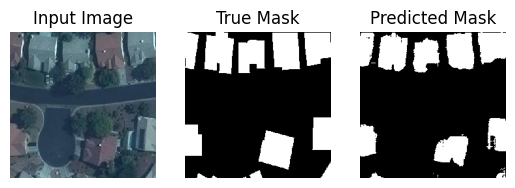


Sample Prediction after epoch 38

127/127 ━━━━━━━━━━━━━━━━━━━━ 1168s 9s/step - accuracy: 0.9434 - loss: 0.1393 - val_accuracy: 0.9320 - val_loss: 0.1813 - learning_rate: 4.0000e-05
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9435 - loss: 0.139


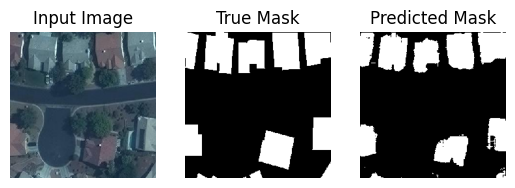


Sample Prediction after epoch 39


Epoch 39: ReduceLROnPlateau reducing learning rate to 1e-05.
127/127 ━━━━━━━━━━━━━━━━━━━━ 1169s 9s/step - accuracy: 0.9436 - loss: 0.1388 - val_accuracy: 0.9320 - val_loss: 0.1813 - learning_rate: 4.0000e-05
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepep - accuracy: 0.9432 - loss: 0.139


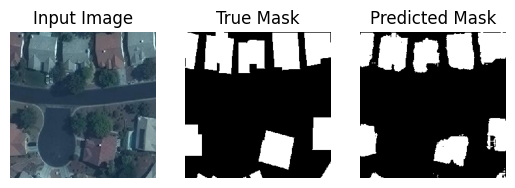


Sample Prediction after epoch 40

127/127 ━━━━━━━━━━━━━━━━━━━━ 1170s 9s/step - accuracy: 0.9432 - loss: 0.1397 - val_accuracy: 0.9330 - val_loss: 0.1781 - learning_rate: 1.0000e-05
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepep - accuracy: 0.9446 - loss: 0.136


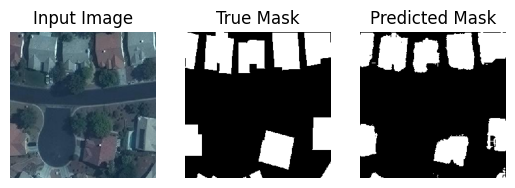


Sample Prediction after epoch 41

127/127 ━━━━━━━━━━━━━━━━━━━━ 1162s 9s/step - accuracy: 0.9446 - loss: 0.1364 - val_accuracy: 0.9330 - val_loss: 0.1779 - learning_rate: 1.0000e-05
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepep - accuracy: 0.9447 - loss: 0.136


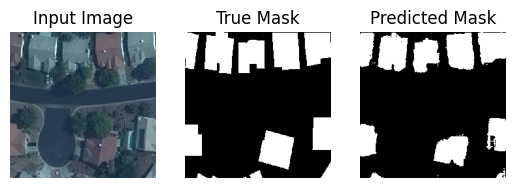


Sample Prediction after epoch 42

127/127 ━━━━━━━━━━━━━━━━━━━━ 1163s 9s/step - accuracy: 0.9447 - loss: 0.1361 - val_accuracy: 0.9331 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9448 - loss: 0.135


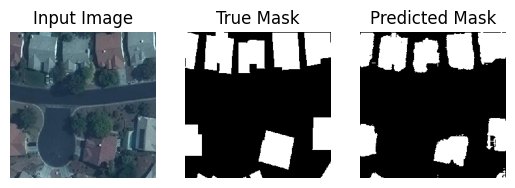


Sample Prediction after epoch 43

127/127 ━━━━━━━━━━━━━━━━━━━━ 1167s 9s/step - accuracy: 0.9448 - loss: 0.1358 - val_accuracy: 0.9331 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9449 - loss: 0.135


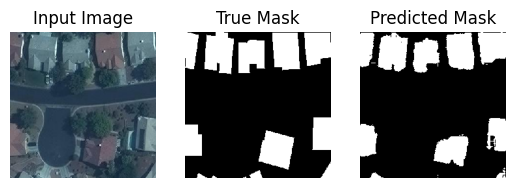


Sample Prediction after epoch 44

127/127 ━━━━━━━━━━━━━━━━━━━━ 1156s 9s/step - accuracy: 0.9450 - loss: 0.1353 - val_accuracy: 0.9331 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9451 - loss: 0.135


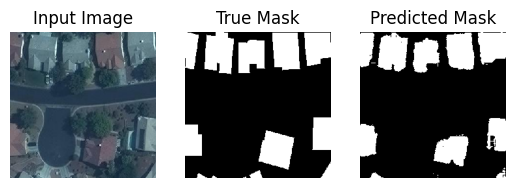


Sample Prediction after epoch 45

127/127 ━━━━━━━━━━━━━━━━━━━━ 1165s 9s/step - accuracy: 0.9451 - loss: 0.1351 - val_accuracy: 0.9331 - val_loss: 0.1782 - learning_rate: 1.0000e-05
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9450 - loss: 0.135


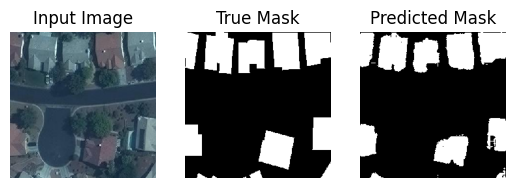


Sample Prediction after epoch 46

127/127 ━━━━━━━━━━━━━━━━━━━━ 1166s 9s/step - accuracy: 0.9450 - loss: 0.1354 - val_accuracy: 0.9331 - val_loss: 0.1783 - learning_rate: 1.0000e-05
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepep - accuracy: 0.9451 - loss: 0.135


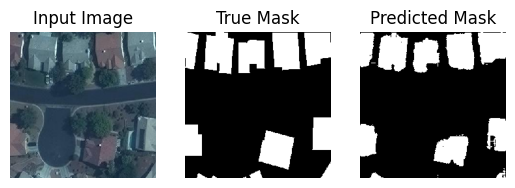


Sample Prediction after epoch 47

127/127 ━━━━━━━━━━━━━━━━━━━━ 1176s 9s/step - accuracy: 0.9452 - loss: 0.1349 - val_accuracy: 0.9331 - val_loss: 0.1783 - learning_rate: 1.0000e-05
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepep - accuracy: 0.9451 - loss: 0.135


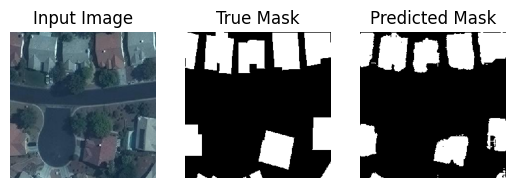


Sample Prediction after epoch 48

127/127 ━━━━━━━━━━━━━━━━━━━━ 1173s 9s/step - accuracy: 0.9452 - loss: 0.1349 - val_accuracy: 0.9330 - val_loss: 0.1784 - learning_rate: 1.0000e-05
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepep - accuracy: 0.9451 - loss: 0.135


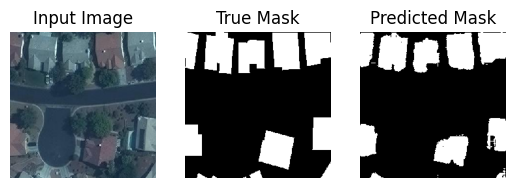


Sample Prediction after epoch 49

127/127 ━━━━━━━━━━━━━━━━━━━━ 1171s 9s/step - accuracy: 0.9452 - loss: 0.1349 - val_accuracy: 0.9331 - val_loss: 0.1784 - learning_rate: 1.0000e-05
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepep - accuracy: 0.9452 - loss: 0.134


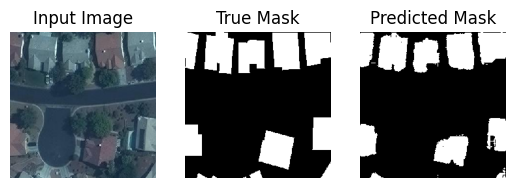


Sample Prediction after epoch 50

127/127 ━━━━━━━━━━━━━━━━━━━━ 1169s 9s/step - accuracy: 0.9452 - loss: 0.1348 - val_accuracy: 0.9331 - val_loss: 0.1785 - learning_rate: 1.0000e-05


In [87]:
EPOCHS = 50
callbacks = [DisplayCallback(), keras.callbacks.ModelCheckpoint("save_at_v2_{epoch}.keras"), CSVLogger('Segmentation_training.csv'),
             keras.callbacks.ModelCheckpoint(filepath="./training_checkpoints/checkpoint_v2_{epoch}.weights.h5", save_weights_only=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=6,verbose=1,mode="auto",min_delta=0.0001,cooldown=1,
            min_lr=1e-5)]

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=val_dataset,
                          callbacks=callbacks)

## Visualize Model Performance & Results

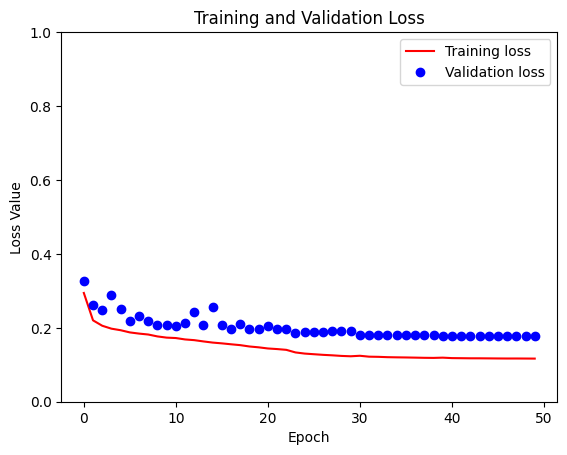

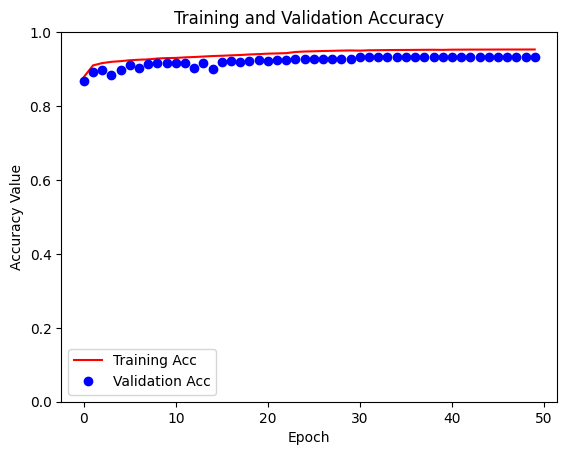

In [88]:
model_history = pd.read_csv(r'/Users/emilyhill/Documents/DeepLearningFinal/Segmentation_training.csv')
#model_history_epochs15_21 = pd.read_csv(r'/Users/emilyhill/Documents/DeepLearningFinal/Segmentation_training.csv')
loss = model_history['loss']
val_loss = model_history['val_loss']
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training Acc')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Test Data Accuracy

Below I predict results for all of the data in my test dataset, so the data that the model has never seen. I calculate the accuracy by getting the percentage of pixels that the model predicted correctly by comparing the output mask to the truth mask. 

In [3]:
loaded_model = keras.saving.load_model(r'/Users/emilyhill/Documents/DeepLearningFinal/save_at_v2_50.keras')

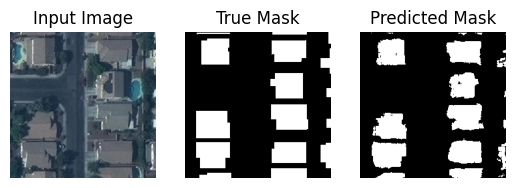

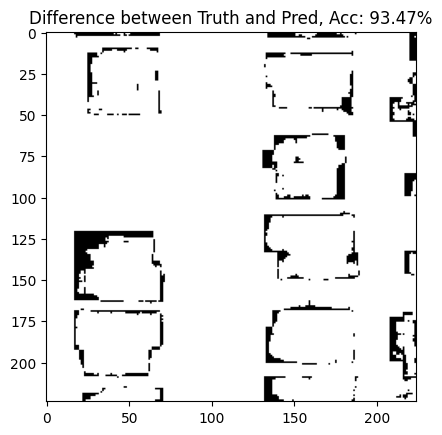

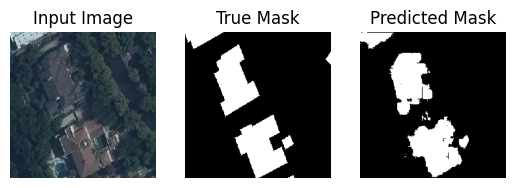

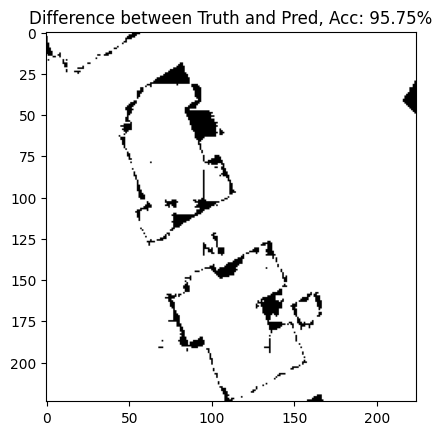

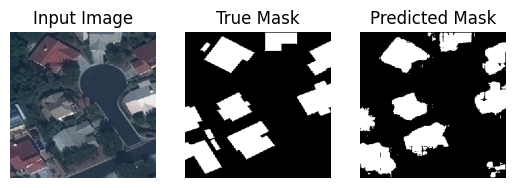

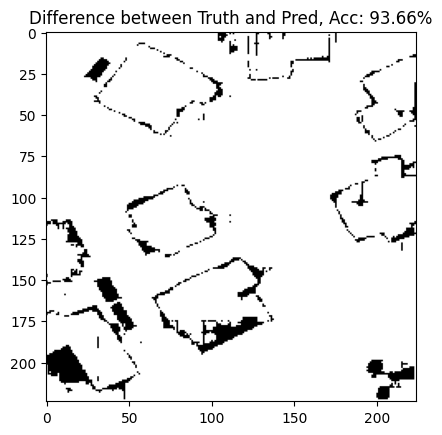

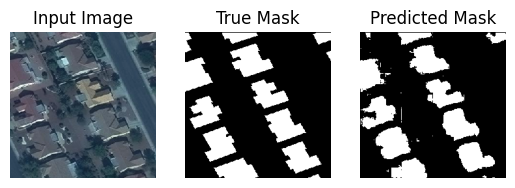

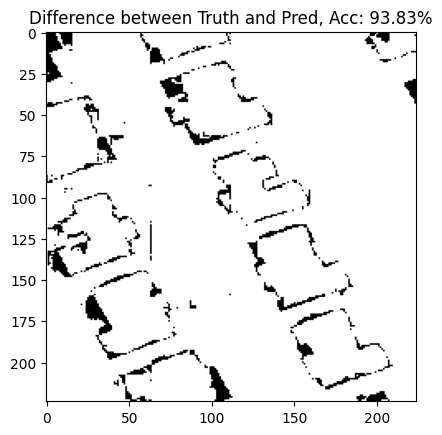

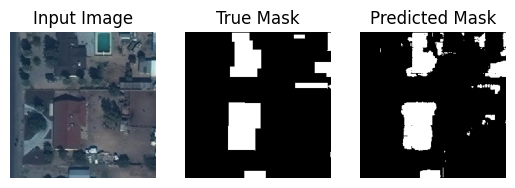

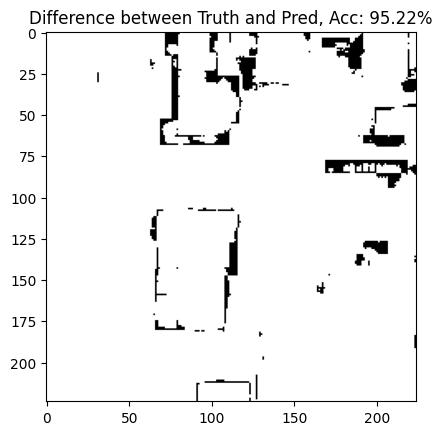

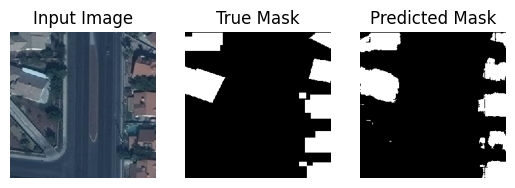

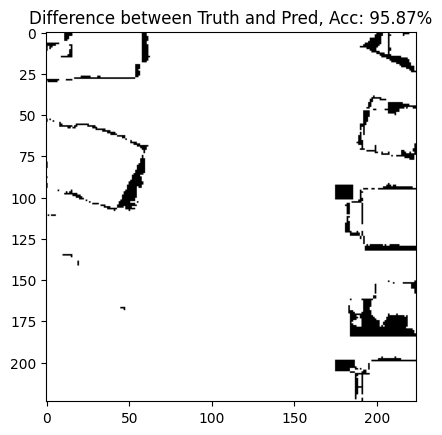

2024-04-29 10:33:04.315296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
total_to_display = 5
disp_num = 0
total_acc = []
for x,y in train_dataset.as_numpy_iterator(): 
    pred = loaded_model.predict(x, verbose=0)
    for i in range(len(x)):
        img = x[i]
        mask = y[i]
        pred_mask = np.expand_dims(np.argmax(pred[i], axis=-1), axis=2)
        diff_mask = pred_mask == mask
        acc = diff_mask.sum()/(diff_mask.shape[0]* diff_mask.shape[1])
        total_acc.append(acc)
        if disp_num <= total_to_display:
            disp_num += 1
            display([img, mask, pred_mask])
            plt.imshow(diff_mask, 'gray')
            plt.title(rf'Difference between Truth and Pred, Acc: {round(acc*100, 2)}%')
            plt.show()

In [36]:
test_acc = np.mean(total_acc)
print('Mean Test Accuracy: ', round(test_acc*100,2), '%')

Mean Test Accuracy:  95.36 %


## Conclusion

This project was overall a success. I wanted to try out some methods for extracting features, this case building, from satellite imagery using a deep learning image segmentation method. I tested out 3 or 4 methods to create my desired U-Net and learned a lot from my research and attempted implimations. On my test dataset, the trained model gets over 95% accuracy for predicting buildings/vs not building masks. I trained this exact model for less epochs multiple times before the training shown here, and found that with too much training data, different batch sizes or leaning rates the training was too slow. Implementing my Learning Rate reducer callback kept the model learning rather than overfitting or stagnating. If I was to do follow on work with different models I discuss what that would entail below. I would have liked to use Intersection over Union (IOU) as a metric but did not have time to implement.

## U-Net Version 2 with sigmoid activation

I created an additional U-Net model for testing but it was not going to train in a reasonable amount of time. If I had additionaly time to work on tis project I would train and compare the results of this U-Net model also. The Original U-Net that I created performs well enough that I was okay not continuing training for the one below. 

In [18]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [19]:
for images, masks in train_dataset.take(1):
    sample_image, sample_mask = images[0], masks[0]
    IMG_HEIGHT = sample_image.shape[0] #224 #image_dataset.shape[1]
    IMG_WIDTH  = sample_image.shape[1] #224 #image_dataset.shape[2]
    IMG_CHANNELS = sample_image.shape[2] #3 #image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

unet2 = build_unet(input_shape, n_classes=1)
unet2.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
unet2.summary()

2024-04-28 14:16:59.134066: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-28 14:16:59.135098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [20]:
callbacks = [keras.callbacks.ModelCheckpoint("unet2_save_at_{epoch}.keras"), CSVLogger('Segmentation_Unet2_training.csv'),
             keras.callbacks.ModelCheckpoint(filepath="./training_checkpoints/unet2_checkpoint_{epoch}.weights.h5", save_weights_only=True)]


history = unet2.fit(train_dataset, 
                    batch_size = 128, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(val_dataset), 
                    shuffle=False,
                    callbacks = callbacks)

Epoch 1/25
 49/254 ━━━━━━━━━━━━━━━━━━━━ 10:19:46 181s/step - accuracy: 0.7853 - loss: 0.4609

KeyboardInterrupt: 